# Code for "Estimating Heterogeneous Agent Models with Neural Networks"
by Hanno Kase, Leonardo Melosi and Matthias Rottner

This code implements the three-equation New Keynesian model (the first proof of concept in the paper) using our neural network method.

The current version of the paper can be found [here](https://matthias-rottner.github.io/Files/KMR_NeuralNetwork_Hank.pdf),
and the code repository is available [here](https://github.com/tseep/estimating-hank-nn)

*Note that we have changed some settings, e.g., the number of iterations, to ensure that the code runs fast in most environments.*

## Disclaimer
*Modified by Qingyuan Fang (JHU) on Nov 20, 2024*

*In preparation for JHU Economics Machine Learning Reading Group meeting on Nov 22, 2024*

*Note: hereafter, "we" refer to the participants of the aforementioned meeting, not the authors of the paper. "I" refer to Qingyuan Fang*.

## Background

### Review: a general framework

* A large class of dynamic GE models whose dynamics are governed by:
	$$ \mathbb{S}_t=f\left(\mathbb{S}_{t-1}, \nu_t \mid \Theta\right)$$
* Solution of the model: find  a set of $O$ policy functions 
    $$\psi_t = \psi(\mathbb{S}_t\mid\Theta)$$
* $K$ equilibrium conditions
    $$F(\psi(\mathbb{S}_t\mid\Theta)) = 0$$


### Punchline: treat the parameters to estimate as pseudo-state variables

* Extended transition equation
    $$ \mathbb{S}_t=f\left(\mathbb{S}_{t-1}, \nu_t, \tilde{\Theta} \mid \bar{\Theta}\right) $$
* Extended policy functions 
    $$ \psi_t = \psi(\mathbb{S}_t, \tilde{\Theta} \mid \bar{\Theta}) $$
* K extended equilibrium conditions
    $$ F(\psi(\mathbb{S}_t, \tilde{\Theta} \mid \bar{\Theta})) = 0 $$
* We want to minimize the weighted loss function
	$$ \text{Min } \Phi^L = \sum_{k = 1}^K \alpha_k \left[F_k(\psi_{NN}(\mathbb{S}_t, \tilde{\Theta} \mid \bar{\Theta}))\right]^2 $$

### Linearized 3-equation NK Model
The model we want to solve is a **three-equation New Keynesian model** with a single shock, specifically a Total Factor Productivity (TFP) shock. The model is log-linearized around its unique steady-state equilibrium, resulting in the following equations:

\begin{align*}
	DIS: \quad &	\hat{X}_t = E_t \hat{X}_{t+1} - \sigma^{-1}\left( \phi_{\Pi}\hat{\Pi}_t+ \phi_Y \hat{X}_{t} - E_t \hat{\Pi}_{t+1} - \hat{R}_t^\ast\right) \\
	NKPC: \quad &	\hat{\Pi}_t = \kappa \hat{X}_t + \beta E_t \hat{\Pi}_{t+1}, \\
  Transition: \quad &	\hat{R}_t^\ast = \rho_A \hat{R}_{t-1}^\ast + \sigma (\rho_A-1)\omega {\sigma_{A}} \epsilon_t^A,
\end{align*}

where output is defined as $\hat{Y}_t=(Y_t-Y)/Y$,  inflation as $\hat{\Pi}_t = \Pi_t-\Pi$, and $\hat{R}_t^\ast$ is the natural rate of interest, which follows an exogenous process that is derived from the TFP process.

$\omega=(1+\eta) /(\eta+\sigma)$, $\kappa=(1-\phi)(1-\phi \beta)(\sigma+\eta) / \phi$

* State variables: $\mathbb{S}_t=\left\{\hat{R}_t^*\right\}$; Structural shocks: $\nu_t=\left\{\epsilon_t^A\right\}$
* Control variables: $\psi_t=\left\{\hat{X}_t, \hat{\Pi}_t\right\}$
* Parameters: $\Theta =\left\{\beta, \sigma, \eta, \phi, \theta_{\Pi}, \theta_Y, \rho_A, \sigma_A\right\}$

### Analytical Solution
$$
\begin{align*}
\hat{X}_t &=\frac{1-\beta \rho_A}{\left(\sigma\left(1-\rho_A\right)+\theta_Y\right)\left(1-\beta \rho_A\right)+\kappa\left(\theta_{\Pi}-\rho_A\right)} \hat{R}_t^* \approx \psi_{NN, 1}\left(\hat{R}_t^*, \beta, \sigma, \eta, \phi, \theta_{\Pi}, \theta_Y, \rho_A, \sigma_A\right) \\
\hat{\Pi}_t &=\frac{\kappa}{\left(\sigma\left(1-\rho_A\right)+\theta_Y\right)\left(1-\beta \rho_A\right)+\kappa\left(\theta_{\Pi}-\rho_A\right)} \hat{R}_t^* \approx \psi_{NN, 2}\left(\hat{R}_t^*, \beta, \sigma, \eta, \phi, \theta_{\Pi}, \theta_Y, \rho_A, \sigma_A\right)
\end{align*}
$$

### Extended Neural Network based Solution
1. Parametrize the policy function with a deep neural network:
    $$
    \binom{\hat{X}_t}{\hat{\Pi}_t}=\psi(\underbrace{\hat{R}_t^F}_{\mathbb{S}_t}, \underbrace{\beta, \sigma, \eta, \phi, \theta_{\Pi}, \theta_Y, \rho_A, \sigma_A}_{\tilde{\Theta}}) \approx \psi_{N N}\left(\hat{R}_t^F, \beta, \sigma, \eta, \phi, \theta_{\Pi}, \theta_Y, \rho_A, \sigma_A\right)
    $$
2. Construct the loss function:
    $$
    \begin{align}
    & E R R_{D I S}=\hat{X}_t - \left[E_t \hat{X}_{t+1}-\sigma^{-1}\left(\phi_{\Pi} \hat{\Pi}_t+\phi_Y \hat{X}_t-E_t \hat{\Pi}_{t+1}-\hat{R}_t^*\right)\right] \\
    & ERRR_{NKPC} = \hat{\Pi}_t - \left(\kappa \hat{X}_t+\beta E_t\hat{\Pi}_{t+1} \right) \\
    & \mathcal{L} = w_1 \frac{1}{B} \sum_{I=1}^B\left(E R R_{D I S}^i\right)^2+w_2 \frac{1}{B} \sum_{i=1}^B\left(E R R_{N K P C}^i\right)^2, \text{where $B$ is the batch size}
    \end{align}
    $$
3. Train the deep neural networks using stochastic optimization. Batch size = 100 (parallel worlds) for 50,000 iterations. 
For the (i)-th iteration:

    1. Draw parameters $\tilde{\Theta}^{(i)}$ from a bounded parameter space 

    2. Draw points from the state space $\hat{R}_t^{*(i)}$ by simulating the model (in order to approximate the stochastic solution domain)

    3. Compute the loss $\mathcal{L}$

    $$ \hat{X}_t = \psi_{NN,1}^{(i)}(\hat{R}_t^{*(i)}, \tilde{\Theta}^{(i)}) $$

    $$ \hat{\Pi}_t = \psi_{NN,2}^{(i)}(\hat{R}_t^{*(i)}, \tilde{\Theta}^{(i)}) $$
    
    $$ E_t\hat{\Pi}_{t+1} = E_t\left[\psi_{NN,2}^{(i)}\left(\hat{R}_{t+1}^{*(i)}, \tilde{\Theta}^{(i)}\right)\right]  = E_t\left[\psi_{NN,2}^{(i)}\left(\rho_A \hat{R}_{t}^{*(i)}+\sigma\left(\rho_A-1\right) \omega \sigma_A \epsilon_{t+1}^A, \tilde{\Theta}^{(i)}\right)\right] \approx \frac{1}{MC}\sum_{m = 1}^{MC} \psi_{NN,2}^{(i)}\left(\rho_A \hat{R}_{t}^{*(i)}+\sigma\left(\rho_A-1\right) \omega \sigma_A \epsilon_{t+1}^{A,m}, \tilde{\Theta}^{(i)}\right) $$
    
    4. Optimizer step (ADAM) to adjust the weights of the NN to minimize $\mathcal{L}$


## Configuration
Now let's get our hands dirty with the code. 

To load the neural network solution for the model set `load_model = True`. 

If set to `False`, the model will be trained from scratch.

In [1]:
# load_model = True

load_model = False

## Load packages

In [2]:
import torch
import math
from pathlib import Path
from copy import deepcopy
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator, NullLocator
import numpy as np
from tqdm import trange

# Style for plots
from estimating_hank_nn.plot_helpers import set_rc_params, style_fig_ax, save_figure

# Structures to hold the elements of the model
from estimating_hank_nn.structures import Parameters, State, Ranges, Shocks

# Neural network layers
from estimating_hank_nn.networks import NormalizeLayer

# Helper functions
from estimating_hank_nn.helpers import ergodic_sigma

## Extended Model Solution with Neural Network Approach
Outline:
1. **Parameters** - set the parameter values, bounds of the model, distribution of the shocks. 

    `NK_par`, `NK_range`, `shock_dist` 

2. **Class for the simple 3 equation NK model** - create a class for the model that has methods to simulate the model, calculate the residuals, calculate the loss, and train the model.

    `model = NKModel(NK_par, NK_range, shock_dist)`

3. **Create the model and train it** - create the model object and train the NN to solve the model.

    `model.train_model(iteration=50000, internal=5, steps=10, batch=100, mc=10, par_draw_after=1, device="cpu", print_after=100, lr=1e-3, eta_min=1e-10)`

### Parameters - See Table 1 of the paper

| Parameters | |LB | UB | Parameters | |LB | UB |
| :--- | :--- | :---: | :---: | :--- | :--- | :---: | :---: |
| $\beta$ | Discount factor | 0.95 | 0.99 | $\theta_{\Pi}$ | Mon.pol. inflation response | 1.25 | 2.5 |
| $\sigma$ | Relative risk aversion | 1 | 3 | $\theta_Y$ | Mon.pol. output response | 0.0 | 0.5 |
| $\eta$ | Inverse Frisch elasticity | 1 | 4 | $\rho_A$ | Persistence TFP shock | 0.8 | 0.95 |
| $\varphi$ | Price duration | 0.5 | 0.9 | $\sigma_A$ | Std. dev. TFP shock | 0.02 | 0.1 |

In [3]:
# NK_par is the true parameters of the model. Let's pretend we don't know these values and we aim to estimate them
# We can also pass a vector of parameters to model.NK_par, simulate the model, and obtain time series of $\hat{X}_t$, $\hat{\Pi}_t$, and $\hat{R}^*_t$
# model.NK_par is unused in the solution part
NK_par = {
    "beta": 0.97,
    "sigma": 2.0,
    "eta": 1.125,
    "phi": 0.7,
    "phipi": 1.875,
    "phiy": 0.25,
    "rho_a": 0.875,
    "sigma_a": 0.06,
}

# Distribution and Bound for the parameters
NK_range = {
    "beta": torch.distributions.Uniform(0.95, 0.99),
    "sigma": torch.distributions.Uniform(1.0, 3.0),
    "eta": torch.distributions.Uniform(0.25, 2.0),
    "phi": torch.distributions.Uniform(0.5, 0.9),
    "phipi": torch.distributions.Uniform(1.25, 2.5),
    "phiy": torch.distributions.Uniform(0.0, 0.5),
    "rho_a": torch.distributions.Uniform(0.8, 0.95),
    "sigma_a": torch.distributions.Uniform(0.02, 0.1),
}

# Distribution for the shock process innovations
shock_dist = {
    "epsilonA": torch.distributions.Normal(0.0, 1.0),
}

### Class for the simple 3 equation NK model

To give an overview, the `NKModel` class has the following methods:
* Convenience methods: 
  * `to` - move the model to a device,
  * `save` - save the model object,
  * `load` - load the model object,
  * `load_attributes` - load the attributes of the model object.
* Neural network methods:
  * `make_network` - create the neural network (multilayer perceptron, or MLP).
* Methods to define the economic model:
  * `steady_state` - calculate the steady state of the model, in this case, the two composite parameters $\kappa$ and $\omega$
  * `policy` - calculate the policy functions of the model (a wrapper around the neural network).
  * `residuals` - calculate the residuals of the model, based on DIS and NKPC. 
  * `loss` - calculate the loss of the model,
* Simulation methods:
  * `initialize_state` - initialize the state of the model,
  * `draw_parameters` - draw parameters from the parameter distribution,
  * `draw_shocks` - draw shocks from the shock distribution,
  * `step` - simulate the model one period ahead, used in training
  * `steps` - simulate the model for a given number of periods ahead, used in training
  * `sim_step` - simulate one step of the model, used in estimation
  * `simulate` - simulate the model for a given number of steps while also recording the simulated time series, used in estimation
* Training methods:
  * `train_model` - train the model,

**In short, the `residuals` method is the most important and effectively defines the economic model.**

In [4]:
class NKModel(object):
    def __init__(self, parameters, ranges, shocks) -> None:
        '''
        Create the NKModel object
        '''
        self.range = Ranges(parameters, ranges)
        self.shock = Shocks(shocks)
        self.par = Parameters(parameters)
        self.par_draw = None
        self.ss = None
        self.state = None
        self.network = self.make_network()
        self.loss_dict = None
        self.training_conf = None

    def to(self, device):
        '''Move the model to a device'''
        self.par.to(device)
        self.par_draw.to(device)
        self.ss.to(device)
        self.state.to(device)
        self.network.to(device)

    def save(self, path, name="model"):
        # Create directory
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save NKModel object
        self.to("cpu")
        with open(f"{path}/{name}.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, path):
        # Load the object
        with open(path, "rb") as f:
            return pickle.load(f)

    def load_attributes(self, path):
        # Load attributes
        with open(path, "rb") as f:
            load = pickle.load(f)

        # Populate attributes
        self.__dict__.update(load.__dict__)

    def make_network(self, N_states=1, N_par=None, N_outputs=2, hidden=32, layers=3, activation=torch.nn.CELU(), normalize=True):
        '''Create the neural network'''

        # Qingyuan: changed the number of hidden layers from 5 to 3, the number of neurons in each hidden layer from 64 to 32, for shorter training time.
        
        # CELU: Continuously Differentiable Exponential Linear Units (continuous version of RELU)
        # https://pytorch.org/docs/stable/generated/torch.nn.CELU.html

        # Detect device --> I used cpu
        device = self.par.values()[0].device

        # Dimension of inputs --> would be 1 + 8 = 9
        if N_par is None:
            N_par = len(self.par)
        N_inputs = N_states + N_par

        # Initialize an empty list to store the layers of the network.
        layer_list = []

        # Normalize layer --> all elements of inputs will be normalized to values between [-1, 1]
        if normalize:
            lb = torch.cat([-torch.ones(N_states, device=device), self.range.low_tensor()], dim=-1)
            ub = torch.cat([+torch.ones(N_states, device=device), self.range.high_tensor()], dim=-1)
            layer_list.append(NormalizeLayer(lb, ub))

        # First layer
        layer_list.append(torch.nn.Linear(N_inputs, hidden))
        layer_list.append(activation)

        # Middle layers
        for _ in range(1, layers):
            layer_list.append(torch.nn.Linear(hidden, hidden))
            layer_list.append(activation)

        # Last layer
        layer_list.append(torch.nn.Linear(hidden, N_outputs))

        # Structure of the NN constructed above: 
        # Inputs(Dim = 9) --> NormalizeLayer(9,9) --> [Linear(9,32) --> CELU] --> [Linear(32,32) --> CELU] * 2 --> Linear(32,2)

        return torch.nn.Sequential(*layer_list)

    def steady_state(self, par=None):
        if par is None:
            par = self.par_draw

        kappa = ((1 - par.phi) * (1 - par.phi * par.beta) * (par.sigma + par.eta)) / par.phi
        omega = (1 + par.eta) / (par.sigma + par.eta)

        return Parameters({"kappa": kappa, "omega": omega})

    def initialize_state(self, par=None, batch=100, multiplier=1.0, device="cpu"):
        if par is None:
            par = self.par_draw

        # Steady state
        ss = self.steady_state(par=par)

        # Ergodic standard deviation of \hat{R}^*
        rho = par.rho_a
        sigma = par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega
        ergodic = ergodic_sigma(rho, sigma)

        # Draw initial value for \hat{R}^* from ergodic distribution
        Rstar = torch.randn((batch, 1), device=device) * ergodic * multiplier

        return State({"Rstar": Rstar})

    def draw_parameters(self, shape, device="cpu"):
        return self.range.sample(shape, device=device)

    # draw epsilon^A_t 
    def draw_shocks(self, shape, antithetic=False, device="cpu"):
        return self.shock.sample(shape, antithetic, device=device)

    def policy(self, state=None, par=None):
        if state is None:
            state = self.state
        if par is None:
            par = self.par_draw

        # Vector of states and parameters
        input_state = state.cat()
        input_par = par.cat()

        # Expand if necessary (for calculating expectations)
        if input_state.ndim > input_par.ndim:
            input_par_shape = list(input_par.shape)
            input_par_shape.insert(0, input_state.size(0))
            input_par = input_par.unsqueeze(0).expand(input_par_shape)

        # Prepare the input by concatenating states and parameters
        input = torch.cat([input_state, input_par], dim=-1)

        # Evaluate the network
        output = self.network(input)

        # Assign and scale the output
        # Qingyuan: changed the scaling factors from 100 to 200
        # Neural network does not like large numbers as output
        X = output[..., 0:1] / 200
        Pi = output[..., 1:2] / 200

        return X, Pi

    @torch.no_grad()
    def step(self, e):
        par = self.par_draw
        ss = self.ss
        state = self.state

        Rstar_next = par.rho_a * state.Rstar + e.epsilonA * par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega

        return State({"Rstar": Rstar_next})

    def steps(self, batch, device, steps):
        for _ in range(steps):
            e = self.draw_shocks((batch, 1), device=device)
            self.state = self.step(e)

    @torch.no_grad()
    def sim_step(self, par=None):
        if par is None:
            par = self.par_draw
        R = self.state.Rstar
        X, Pi = self.policy(self.state, par)
        return {"R": R, "X": X, "Pi": Pi}

    @torch.no_grad()
    def simulate(self, batch, par=None, burn=99, steps=101, device="cpu", seed=None):
        # Manual seed
        if seed is not None:
            torch.manual_seed(seed)

        # Set parameters and dimensions
        if par is None:
            self.par_draw = self.par.expand((batch, 1))
        else:
            self.par_draw = par.expand((batch, 1))

        # Change the device of the model
        self.to(device)

        # Initialize
        self.state = self.initialize_state(batch=batch, device=device)
        self.ss = self.steady_state()

        # Burn-in
        self.steps(batch=batch, device=device, steps=burn)

        # Simulate
        results = {"R": [], "X": [], "Pi": []}
        for _ in range(steps):
            out = self.sim_step()

            # Store results
            for key, value in out.items():
                results[key].append(value.squeeze(-1))

            # Update state
            e = self.draw_shocks((batch, 1), device=device)
            self.state = self.step(e)

        # Stack results
        for key, value in results.items():
            results[key] = torch.stack(value, dim=-1)

        return results

    def residuals(self, e):
        par = self.par_draw
        ss = self.ss
        state = self.state

        # Output gap and inflation at period t
        X, Pi = self.policy(self.state, self.par_draw)

        # Next period state \hat`R^*_{t+1}
        # e is MC dimensional, this will also be MC dimensional
        state_next = self.step(e)

        # Expected output gap and inflation period t+1 (numerical integration: take the mean of the MC-dimensional output)
        X_next, Pi_next = self.policy(state_next, self.par_draw)
        EX_next = torch.mean(X_next, dim=0)
        EPi_next = torch.mean(Pi_next, dim=0)

        # Residuals
        nkpc = Pi - (ss.kappa * X + par.beta * EPi_next)
        bond_euler = X - (EX_next - 1 / par.sigma * (par.phipi * Pi + par.phiy * X - EPi_next - state.Rstar))

        return torch.sum(nkpc**2), torch.sum(bond_euler**2)

    def loss(self, nkpc, bond_euler, batch, weights=[1.0, 1.0]):
        loss = weights[0] * nkpc + weights[1] * bond_euler
        return loss, {"nkpc": nkpc / batch, "bond_euler": bond_euler / batch}

    def train_model(
        self,
        iteration=10000,      # Number of iterations
        internal=1,           # Number of internal optimization steps
        steps=10,             # Number of simulation steps to perform after each iteration
        batch=100,            # Batch size
        mc=10,                # Number of Monte Carlo simulations for expectations
        par_draw_after=100,   # Draw new parameters after this many iterations
        lr=1e-3,              # Learning rate
        eta_min=1e-10,        # Minimum learning rate for the scheduler
        device="cpu",
        print_after=100,      # Print running loss after this many iterations
    ):
        # Save training configuration
        self.training_conf = locals().copy()
            
        # Print training configuration
        print("Training configuration:")
        for key, value in self.training_conf.items():
            if key != "self":
                print(f"{key}: {value}")

        # Set the network to train mode
        self.network.train()
        self.network.to(device)

        # Initialize
        self.par_draw = self.draw_parameters(shape=(batch, 1), device=device)
        self.state = self.initialize_state(batch=batch, device=device)
        self.ss = self.steady_state()

        # Starting weights for loss components
        weights = [1.0, 1.0]

        # Optimizer and scheduler
        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iteration, eta_min=eta_min)

        # Dictionary for loss
        self.loss_dict = {"iteration": [], "total": [], "nkpc": [], "bond_euler": []}

        # Progress bar
        pbar = trange(iteration)

        # Training loop
        running_loss = 0.0
        for i in pbar:
            for o in range(internal):
                optimizer.zero_grad()
                e = self.draw_shocks((mc, batch, 1), antithetic=True, device=device)
                nkpc, bond_euler = self.residuals(e)
                loss, loss_components = self.loss(nkpc, bond_euler, batch=batch, weights=weights)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 1.0)
                optimizer.step()

                # Record loss
                if o == 0:
                    self.loss_dict["iteration"].append(i)
                    self.loss_dict["total"].append(loss.item())
                    for key, value in loss_components.items():
                        self.loss_dict[key].append(value.item())

                    # Running loss
                    running_loss += loss.item() / batch

            # Print running loss in the progress bar after 100 iterations
            if i % print_after == 0:
                pbar.set_postfix({"lr:": scheduler.get_last_lr()[0], "loss": running_loss / print_after})
                running_loss = 0.0

            # Update learning rate
            scheduler.step()

            # Draw new parameters
            if i % par_draw_after == 0:
                self.par_draw = self.draw_parameters((batch, 1), device=device)
                self.ss = self.steady_state()

            # Sample states by simulation
            self.steps(batch=batch, device=device, steps=steps)

        # Set network to evaluation mode
        self.network.eval()

I recommend to take a closer look at the following methods: 
* `make_network`: learn how PyTorch builds the architecture of the neural network in a modular way.

* `policy`: given the parameter and the state at $t$, concatenate them into a 9-dimensional vector as input $(\hat{R}^*_t, \tilde{\Theta})$, pass it through the neural network, and return the 2-dimensional output $(\hat{X}_t, \hat{\Pi}_t)$.

* `step`: given the parameter, the state at t, and the shock drawn for t+1, use the transition equation to obtain the state for t+1, $\hat{R}_{t+1}^*$

* `steps`: given the parameter, the state at t, draw the shock for t+1, t+2, ..., t+steps, and use the transition equation to obtain the state for t+steps, $\hat{R}_{t+steps}^*$

* `residuals`: given the parameter, the state at t, 

    1. pass $(\hat{R}_{t}^*, \tilde{\Theta})$ through the neural network to obtain $(\hat{X}_{t}, \hat{\Pi}_{t})$

    2. draw MC shocks for period t+1

    3. use the transition equaition to obtain $\hat{R}_{t+1}^*$ for each one of these shocks

    4. pass $(\hat{R}_{t+1}^*, \tilde{\Theta})$ through the neural network to obtain $(\hat{X}_{t+1}, \hat{\Pi}_{t+1})$ for each one of these shocks
    
    5. average over MC $\hat{X}_{t+1}$ and MC $\hat{\Pi}_{t+1}$ to obtain the approximated $E_t\hat{X}_{t+1}$ and $E_t\hat{\Pi}_{t+1}$

    6. plug $(\hat{R}_{t}^*, \tilde{\Theta}, \hat{X}_{t}, \hat{\Pi}_{t}, E_t\hat{X}_{t+1}, E_t\hat{\Pi}_{t+1})$ into the DIS and NKPC equations to obtain the residuals

       Note: if batch > 1, we will obtain the residuals for each batch, and take the average of these residuals over the batches

* `loss`: calculate the weighted sum of the two residuals from the two equations

Let's skip `train_model` for now. 

### Initialze the model

In [5]:
# Create the model object
model = NKModel(NK_par, NK_range, shock_dist)

In [6]:
# What does this object looks like?
# Take a look at model.network, notice how nicely PyTorche has organized the layers of the neural network!
model.__dict__.keys(), model.__dict__

(dict_keys(['range', 'shock', 'par', 'par_draw', 'ss', 'state', 'network', 'loss_dict', 'training_conf']),
 {'range': beta: Uniform(low: 0.949999988079071, high: 0.9900000095367432)
  sigma: Uniform(low: 1.0, high: 3.0)
  eta: Uniform(low: 0.25, high: 2.0)
  phi: Uniform(low: 0.5, high: 0.8999999761581421)
  phipi: Uniform(low: 1.25, high: 2.5)
  phiy: Uniform(low: 0.0, high: 0.5)
  rho_a: Uniform(low: 0.800000011920929, high: 0.949999988079071)
  sigma_a: Uniform(low: 0.019999999552965164, high: 0.10000000149011612),
  'shock': epsilonA: Normal(loc: 0.0, scale: 1.0),
  'par': beta: tensor([0.9700])
  sigma: tensor([2.])
  eta: tensor([1.1250])
  phi: tensor([0.7000])
  phipi: tensor([1.8750])
  phiy: tensor([0.2500])
  rho_a: tensor([0.8750])
  sigma_a: tensor([0.0600]),
  'par_draw': None,
  'ss': None,
  'state': None,
  'network': Sequential(
    (0): NormalizeLayer()
    (1): Linear(in_features=9, out_features=32, bias=True)
    (2): CELU(alpha=1.0)
    (3): Linear(in_features=32,

### Detailed explanation of the training process
The authors then train the model using one line of code

`model.train_model(iteration=50000, internal=5, steps=10, batch=100, mc=10, par_draw_after=1, device="cpu", print_after=100, lr=1e-3, eta_min=1e-10)`

How does this work? I'll break it into pieces. You can cross-reference with the method `train_model` in the `NKModel` class if you like.

Inputs:

* `iteration=50000`: the number of iterations to train the model.

* `batch=100`: the number of parallel universes for each training iteration (they run independently until step 6 of the `residual` method)

* `mc=10`: the number of Monte Carlo simulations to approximate the expectation. See step 2 - step 5 of the `residuals` method.

* `device="cpu"`: the device to train the model on.

* `print_after=100`: the number of iterations after which to print the loss. Not important.

* `lr=1e-3`: the starting learning rate of the optimizer.

* `eta_min=1e-10`: the minimum learning rate of the optimizer. The learning rate is gradually reduced from lr = 1e-3 to this value. The higher the iteration, the lower the learning rate.

I'll explain the following inputs later:

* `internal=5`: the number of internal iterations to simulate the model for each training iteration. 

* `steps=10`: the number of steps to simulate the model for each training iteration.

* `par_draw_after=1`: the number of iterations to draw new parameters.


In [7]:
# After we run that one line of code above, here is what will happen, in steps:
# Let's set batch size = 2 for now

# draw parameters for period t
model.par_draw = model.draw_parameters((2, 1))
model.par_draw.__dict__

{'beta': tensor([[0.9812],
         [0.9631]]),
 'sigma': tensor([[1.7587],
         [1.3585]]),
 'eta': tensor([[1.0659],
         [0.5110]]),
 'phi': tensor([[0.7776],
         [0.6786]]),
 'phipi': tensor([[1.5605],
         [2.3303]]),
 'phiy': tensor([[0.1032],
         [0.3067]]),
 'rho_a': tensor([[0.9305],
         [0.8530]]),
 'sigma_a': tensor([[0.0452],
         [0.0406]])}

In [8]:
# Given model.par_draw, draw a value of \hat{R}^* from its ergodic distribution
model.state = model.initialize_state(batch = 2)
model.state.__dict__

{'Rstar': tensor([[ 0.0065],
         [-0.0037]])}

In [9]:
# compute the composite parameters
model.ss = model.steady_state()
model.ss.__dict__

{'kappa': tensor([[0.1914],
         [0.3068]]),
 'omega': tensor([[0.7314],
         [0.8083]])}

In [10]:
# Set the network to train mode
model.network.train()

# send the network to the device ("cpu")
model.network.to("cpu")

# Initialize the optimizer, schduler.
optimizer = torch.optim.AdamW(model.network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50000, eta_min=1e-10)

# Define the weights assigned to the two residuals (one from DIS, the other from NKPC). We also decide to keep track of the loss as iteration proceeds.
weights = [1.0, 1.0]
model.loss_dict = {"iteration": [], "total": [], "nkpc": [], "bond_euler": []}
running_loss = 0.0

In [11]:
# The NN is ready to be trained now.
optimizer.param_groups[0]['params'][-1] # here I print the (initialized) bias of the last layer (output layer)

Parameter containing:
tensor([ 0.1763, -0.1103], requires_grad=True)

**For each one of the 50000 iterations, we will do the following things (assume we are at iteration (i)):**

Given the current parameter $\tilde{\Theta}^{(i)}$:, and current state $\hat{R}_t^{*(i)}$:

Step 1. Internal loop (essentially "resusing" the same $(\hat{R}_t^{*(i)}, \tilde{\Theta}^{(i)}$ for a few times):

In [12]:
for o in range(10):
    # the following block of code is executed for "internal = 10" times

    # initialize gradients to None to save memory (because we need to recalculate the gradients each time `loss.backward()` is applied).
    optimizer.zero_grad()

    # draw MC = 10 $t+1$ shocks $\epsilon^A_t+1$ for each of the 2 batches
    # the antithetics method is used to reduce the variance of the Monte Carlo integration
    # ref: https://en.wikipedia.org/wiki/Antithetic_variates
    e = model.draw_shocks((10, 2, 1), antithetic=True, device="cpu")

    # calculate the residuals (averages across the two batches) of the model
    nkpc, bond_euler = model.residuals(e)

    # take the weighted sum of the residuals to get the loss (a scalar)
    loss, loss_components = model.loss(nkpc, bond_euler, batch=1, weights=weights) #--> you can record the progress of the loss if you want

    # calculate the gradients \partial loss / \partial weight for each weight in the network, \partial loss / \partial bias for each bias in the network
    loss.backward()

    # clip the gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.network.parameters(), 1.0)

    # update the weights and biases of the network
    optimizer.step()

    # I added this line. It will print the bias of the last layer.
    print(optimizer.param_groups[0]['params'][-1]) # weight of the last layer

Parameter containing:
tensor([ 0.1753, -0.1113], requires_grad=True)
Parameter containing:
tensor([ 0.1743, -0.1123], requires_grad=True)
Parameter containing:
tensor([ 0.1733, -0.1133], requires_grad=True)
Parameter containing:
tensor([ 0.1723, -0.1142], requires_grad=True)
Parameter containing:
tensor([ 0.1714, -0.1151], requires_grad=True)
Parameter containing:
tensor([ 0.1705, -0.1160], requires_grad=True)
Parameter containing:
tensor([ 0.1696, -0.1168], requires_grad=True)
Parameter containing:
tensor([ 0.1687, -0.1175], requires_grad=True)
Parameter containing:
tensor([ 0.1679, -0.1182], requires_grad=True)
Parameter containing:
tensor([ 0.1672, -0.1187], requires_grad=True)


Step 2. Update (decrease) the learning rate

In [13]:
scheduler.step()

Step 3. Every `par_draw_after` iterations, we draw new parameters. 

The authors set `par_draw_after` = 1, so we draw new parameters every iteration.

In [14]:
# if (i) % par_draw_after == 0:
#     model.par_draw = model.draw_parameters((2, 1), device="cpu")
#     model.ss = model.steady_state()

Step 4. Draw the new state for the next iteration 

Here the idea of stochastic solution domain kicks in. 

Given the new parameter $\tilde{\Theta}^{(i+1)}$ and the original state $\hat{R}_t^{*(i)}$, we simulate the model for `steps` periods (using the transition equation) to obtain the new state $\hat{R}_{t+step}^{*(i)}$. We will take this new state as the state for the next iteration, aka $\hat{R}_t^{*(i+1)}$. The value of $\hat{R}_t^*$ whic has a higher density (based on its ergodic distribution) will be more likely to be drawn, and solved by the model.

In [15]:
# model.steps(batch=2, device="cpu", steps=10)

**After all the iterations are done, we set the model to evaluation mode**

In [16]:
#model.network.eval()

### Train the model

In [17]:
# Let's initialize the model again and train it
# I trained the model using cpu on an M2 Max Macbook Pro. It took about 5 minutes.

model = NKModel(NK_par, NK_range, shock_dist)
if not load_model:
    model.train_model(iteration=50000, internal=5, steps=10, batch=100, mc=10, par_draw_after=1, device="cpu", print_after=100, lr=1e-3, eta_min=1e-10)

Training configuration:
iteration: 50000
internal: 5
steps: 10
batch: 100
mc: 10
par_draw_after: 1
lr: 0.001
eta_min: 1e-10
device: cpu
print_after: 100


100%|██████████| 50000/50000 [05:00<00:00, 166.64it/s, lr:=9.97e-9, loss=3.48e-8] 


In [18]:
# Save the model
if not load_model:
    model.save(path="save", name="analytical_example")

## Check the solution

### Load the saved model

In [19]:
# Load the model trained by ourselves
model = NKModel.load("save/analytical_example.pkl")

# Load the model trained by the authors
# model = NKModel.load("save/authors_backup/analytical_example.pkl")

# Set the style for the plots
set_rc_params()

Note: I made no change to the codes below.

### Figure: average loss and the loss of the two residual equations.

In [20]:
def plot_loss(loss_dict, ylim=None, ma=1000, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(10.0 / 1.55, 5.0 / 1.55))

    # Calculate mean over all loss components (except iteration and total)
    total_avg = np.zeros_like(np.array(loss_dict["total"]))
    for key, value in loss_dict.items():
        if key not in ["iteration", "total"]:
            total_avg += np.array(value)
    total_avg /= len(loss_dict) - 2

    # Add total_avg to loss_dict
    loss_dict["total_avg"] = total_avg.tolist()

    # Moving average over loss
    tmp_dict = {key: np.convolve(value, np.ones(ma), "valid") / ma for key, value in loss_dict.items()}

    # Plot losses, including legend
    ax[0].plot(tmp_dict["iteration"], tmp_dict["total_avg"])
    ax[0].set_title("Average loss")
    ax[0].set_yscale("log")
    if ylim is not None:
        ax[0].set_ylim(ylim)
    else:
        ylim = ax[0].get_ylim()
    ax[0].grid()
    ax[1].plot(tmp_dict["iteration"], tmp_dict["nkpc"])
    ax[1].set_title("NKPC loss")
    ax[1].set_yscale("log")
    ax[1].set_ylim(ylim)
    ax[1].grid()
    ax[2].plot(tmp_dict["iteration"], tmp_dict["bond_euler"])
    ax[2].set_title("Bond Euler loss")
    ax[2].set_yscale("log")
    ax[2].set_ylim(ylim)
    ax[2].grid()

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax)

    return fig, ax

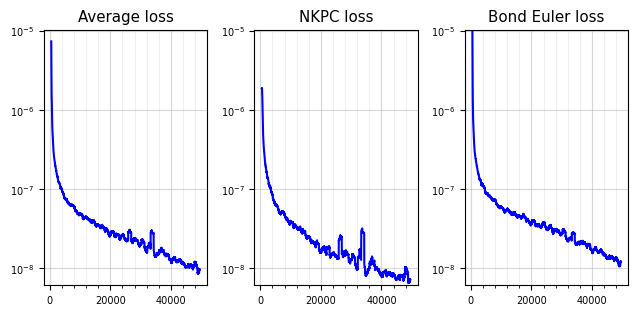

In [21]:
fig_loss, _ = plot_loss(model.loss_dict, ma=1000)

In [22]:
# Analytical policy function
def policy_analytical(state, par):
    # Calculate steady state
    kappa = ((1 - par.phi) * (1 - par.phi * par.beta) * (par.sigma + par.eta)) / par.phi
    omega = (1 + par.eta) / (par.sigma + par.eta)
    ss = Parameters({"kappa": kappa, "omega": omega})

    # Calculate policy
    X = (1 - par.beta * par.rho_a) * state.Rstar / ((par.sigma * (1 - par.rho_a) + par.phiy) * (1 - par.beta * par.rho_a) + ss.kappa * (par.phipi - par.rho_a))
    Pi = ss.kappa * state.Rstar / ((par.sigma * (1 - par.rho_a) + par.phiy) * (1 - par.beta * par.rho_a) + ss.kappa * (par.phipi - par.rho_a))

    return X, Pi

In [23]:
def policy_over_par(model, shock_std=0.0, par=None, par_name="beta", n=100, analytical=False):
    par_range = model.range.get(par_name)
    lower_bound = par_range.support.lower_bound
    upper_bound = par_range.support.upper_bound
    grid = torch.linspace(lower_bound, upper_bound, n).view(-1, 1)

    if par is None:
        par = deepcopy(model.par)

    Pi_list = []
    X_list = []

    for g in grid:
        # Set parameter
        par.set(par_name, g)

        # Steady state
        ss = model.steady_state(par=par)

        # Set state
        sigma = par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega
        state = State({"Rstar": torch.tensor([shock_std * sigma])})

        with torch.no_grad():
            if analytical:
                X, Pi = policy_analytical(state=state, par=par)
            else:
                X, Pi = model.policy(state=state, par=par)
            Pi_list.append(Pi)
            X_list.append(X)

        out = {"grid": grid, "X": torch.cat(X_list, dim=0), "Pi": torch.cat(Pi_list, dim=0)}

    return out

In [24]:
def policy_over_par_list(model, shock_std=-1.0, par_list=None, n=100, analytical=False):
    if par_list is None:
        par_list = model.par.keys()

    out = {}
    for par_name in par_list:
        grid, X, Pi = policy_over_par(model, shock_std, par_name=par_name, n=n, analytical=analytical).values()
        out[par_name] = {"grid": grid, "X": X, "Pi": Pi}

    return out

### Figures 3 and 9 in the paper: compare the analytical solution and the neural network solution

*Note that the figure may deviate from the one in the paper because I changed some settings of the neural network

In [25]:
def plot_par_list(model, shock_std=-1.0, policy="Pi", par_list=None, n=100, fig=None, ax=None):
    # Some constants
    n_cols = 2
    n_rows = 4
    y_space = 0.001
    if par_list is None:
        par_list = model.par.keys()

    # Create figure and axes if not provided
    if fig is None and ax is None:
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(10.0 / 1.55, 13 / 1.55))

    # Font size
    plt.rc("font", size=7)

    # Analytical and numerical solutions
    ana = policy_over_par_list(model, shock_std, par_list=par_list, n=n, analytical=True)
    num = policy_over_par_list(model, shock_std, par_list=par_list, n=n, analytical=False)

    # Add titles and ylabel strings
    if policy == "Pi":
        title = r"PF $\hat{\Pi}_t$ conditioned on "
    elif policy == "X":
        title = r"PF $\hat{X}_t$ conditioned on "

    par_latex = [r"$\beta$", r"$\sigma$", r"$\eta$", r"$\phi$", r"$\phi_{\Pi}$", r"$\phi_{Y}$", r"$\rho_A$", r"$\sigma_A$"]

    ylabel_list = [
        "Discount factor",
        "Relative risk aversion",
        "Inverse Frisch elasticity",
        "Price duration",
        "MP inflation response",
        "MP output response",
        "Persistence shock",
        "Standard deviation shock",
    ]

    for i, key in enumerate(par_list):
        row = i // n_cols
        col = i % n_cols
        ax[row, col].plot(num[key]["grid"], num[key][policy], label="Neural network", linewidth=1.5, color="blue")
        ax[row, col].plot(ana[key]["grid"], ana[key][policy], label="Analytical solution", linewidth=1.5, linestyle="dashed", color="red")
        ax[row, col].set_title(f"{title} {par_latex[i]}")
        ax[row, col].set_xlabel(f"{ylabel_list[i]} {par_latex[i]}")

        ymin = torch.min(ana[key][policy]).item()
        ymax = torch.max(ana[key][policy]).item()
        xmin = torch.min(ana[key]["grid"]).item()
        xmax = torch.max(ana[key]["grid"]).item()
        ax[row, col].set_ylim(bottom=ymin - y_space, top=ymax + y_space)
        ax[row, col].set_xlim(left=xmin, right=xmax)

        ax[row, col].tick_params(axis="both", which="major", labelsize=6)
        ax[row, col].tick_params(axis="both", which="minor", labelsize=6)

        # Add legend in the last subplot
        if i == len(par_list) - 1:
            ax[row, col].legend(loc="lower right")

    # Adjust layout
    fig.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax, xminor=5, yminor=4)

    return fig, ax

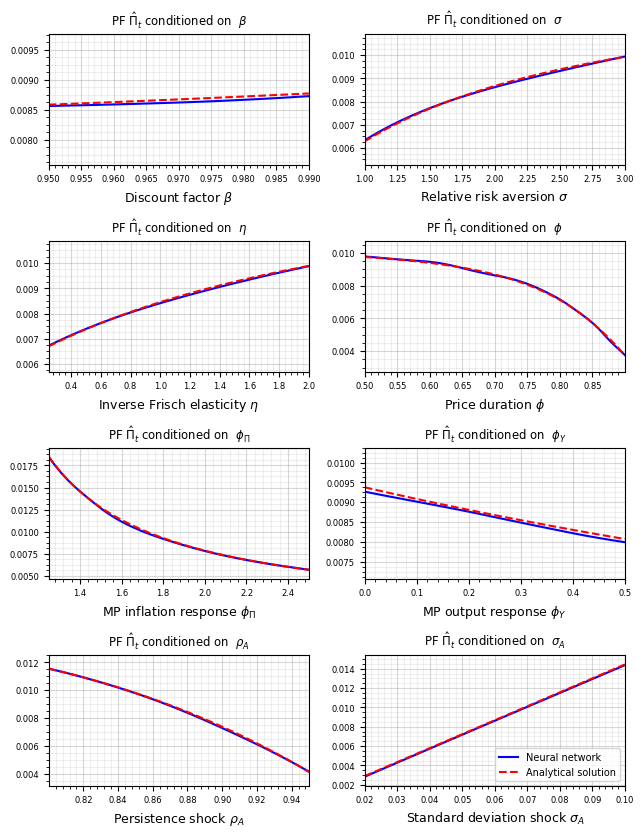

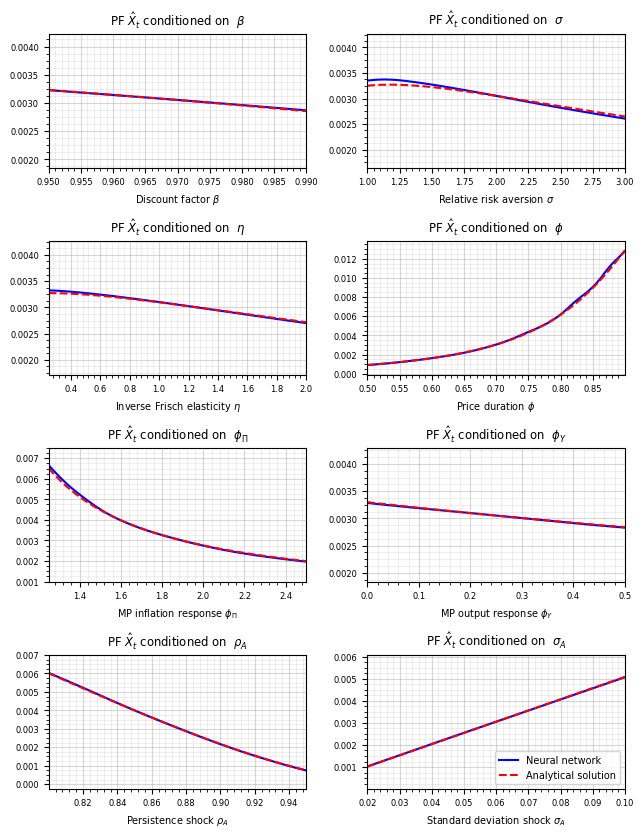

In [26]:
fig_Pi_par_list, _ = plot_par_list(model, shock_std=-1.0, policy="Pi", par_list=None, n=100)
# save_figure(fig_Pi_par_list, f"{directory}/solution_comparison_Pi")

fig_X_par_list, _ = plot_par_list(model, shock_std=-1.0, policy="X", par_list=None, n=100)
# save_figure(fig_X_par_list, f"{directory}/solution_comparison_X")

## Estimation - search for "optimal" parameters
* Policy functions learned from the extended NN: 
$$
\left(\begin{array}{l}
    \hat{X}_t \\
    \hat{\Pi}_t
\end{array}\right)=\psi_{NN}\left(\hat{R}_t^*, \tilde{\Theta} \right)
$$
* Transition equation of the states
$$\hat{R}_t^* = \rho_A \hat{R}_{t-1}^*+\sigma\left(\rho_A-1\right) \omega \sigma_A \epsilon_t^A = f(\hat{R}_{t-1}^*, \epsilon_t^A, \tilde{\Theta}) $$

Recall that the model is trained treating parameters as pseudo-state variables. Therefore, given any parameters (within the bounds), solving and simulating the model is almost free!


### GMM
Given a parameter vector $\tilde{\Theta}$, we can simulate the model to obtain the simulated data. We search for $\tilde{\Theta}$ to minimize the distance between moments of the simulated data and the moments of the actual data.

In [27]:
# simulate the data
data = model.simulate(seed=1234, batch=1, burn=1000, steps=1000, device="cpu")
data.keys(), data["X"].shape

(dict_keys(['R', 'X', 'Pi']), torch.Size([1, 1000]))

### IRF Matching
Given a parameter vector $\tilde{\Theta}$, for a given TFP shock at period 0, we can simulate the path of $\hat{R}^*$, $\hat{X}_t$, $\hat{\Pi}_t$ for $t=0,1,2,...,T$. We search for $\tilde{\Theta}$ to minimize the distance between the simulated IRF and the actual IRF.

### Filtering

Given a parameter vector $\tilde{\Theta}$, and observed time series of $(\hat{X}_t, \hat{\Pi}_t, \hat{R}^*_t)$ for $t=1,1,2,...,T$

* Measurement equation
$$ 
\mathbb{Y}_t^{Ob} = \left(\begin{array}{l}
    \hat{X}_t^{Ob} \\
    \hat{\Pi}_t^{Ob} \\
    \hat{R}_t^{* Ob}
\end{array}\right)=	
\left(\begin{array}{l}
    \psi_{NN,1} \\
    \psi_{NN,2} \\
    \mathbb{I}
\end{array}\right)\left(\hat{R}_t^*, \tilde{\Theta} \right) + u_t
$$

* Transition equation
$$\hat{R}_t^* = f(\hat{R}_{t-1}^*, \epsilon_t^A, \tilde{\Theta}) $$

* $u_t$ and $\epsilon_t$ are assumed to follow a certain distribution

$$(\tilde{\Theta}, \mathbb{Y}_{1:T}^{Ob}) - \fbox{Particle  Filter} \rightarrow \mathbb{L}(\mathbb{Y}_{1:T}^{Ob}|\tilde{\Theta})$$ 

where $\mathbb{L}$ is the log-likelihood function

* Particle filter (sequential MC filtering) can be very time consuming for complex models

* We can use a surrogate NN to approximate the likelihood function. See the authors' notebook "analytical.ipynb" for details.